### Excercise 5.7

<font color='red'>1 Redefine the model to be w2 * t_u ** 2 + w1 * t_u + b.<br></font>
<font color='red'>a What parts of the training loop, and so on, need to change to accommodate this redefinition?<br></font>
ans> We need to change the model definition and we need to assign initial values for w2, w1 and b

<font color='red'>b What parts are agnostic to swapping out the model?<br></font>
ans> Except the above changes everything else remains the same. Tuning the learning rate can lead to decreased loss.

<font color='red'>c Is the resulting loss higher or lower after training?<br></font>
ans> The resulting loss is the higher for non-linear model than linear given the number of epochs and learning rate remain the same for both cases.
If either one of learning rate or number of epochs is increased, the loss on non-linear model matches the loss on the linear model.

<font color='red'>d Is the actual result better or worse?<br></font>
ans> The actual result is more or less same for both instances of the model.
The reason is the relationship between the true and unknown data is inherently linear.
The notable difference is that the non-linear model is capturing more data points which are noise or outliers than the linear model.

In [7]:
%matplotlib inline
import numpy as np
import torch
torch.set_printoptions(edgeitems=2, linewidth=75)
import torch.optim as optim

In [8]:
t_c = torch.tensor([0.5, 14.0, 15.0, 28.0, 11.0,
                    8.0, 3.0, -4.0, 6.0, 13.0, 21.0])
t_u = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9,
                    33.9, 21.8, 48.4, 60.4, 68.4])
t_un = 0.1 * t_u

<font color='red'> a What parts of the training loop, and so on, need to change to accommodate this redefinition?<br></font>


In [9]:
def model(t_u, w1, w2, b):
    return w2 * t_u ** 2 + w1 * t_u + b

In [10]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [11]:
def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params) 
        loss = loss_fn(t_p, t_c)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            
    return params

In [19]:
# params = torch.tensor([0.01,0.5, 0.0], requires_grad=True)
params = torch.tensor([0.0,0.0, 1.0], requires_grad=True)
learning_rate = 1e-1  #1e-2
optimizer = optim.Adam([params], lr=learning_rate) # <1>

training_loop(
    n_epochs = 5000,  #5000
    optimizer = optimizer,
    params = params,
    t_u = t_u, # <2> non-normalized inputs
    t_c = t_c)

Epoch 500, Loss 3.966584
Epoch 1000, Loss 3.820024
Epoch 1500, Loss 3.624689
Epoch 2000, Loss 323.648712
Epoch 2500, Loss 3.285815
Epoch 3000, Loss 3.021137
Epoch 3500, Loss 2.873159
Epoch 4000, Loss 4.042927
Epoch 4500, Loss 2.648123
Epoch 5000, Loss 2.559777


tensor([ 3.2953e-02,  4.7707e-03, -5.1584e+00], requires_grad=True)

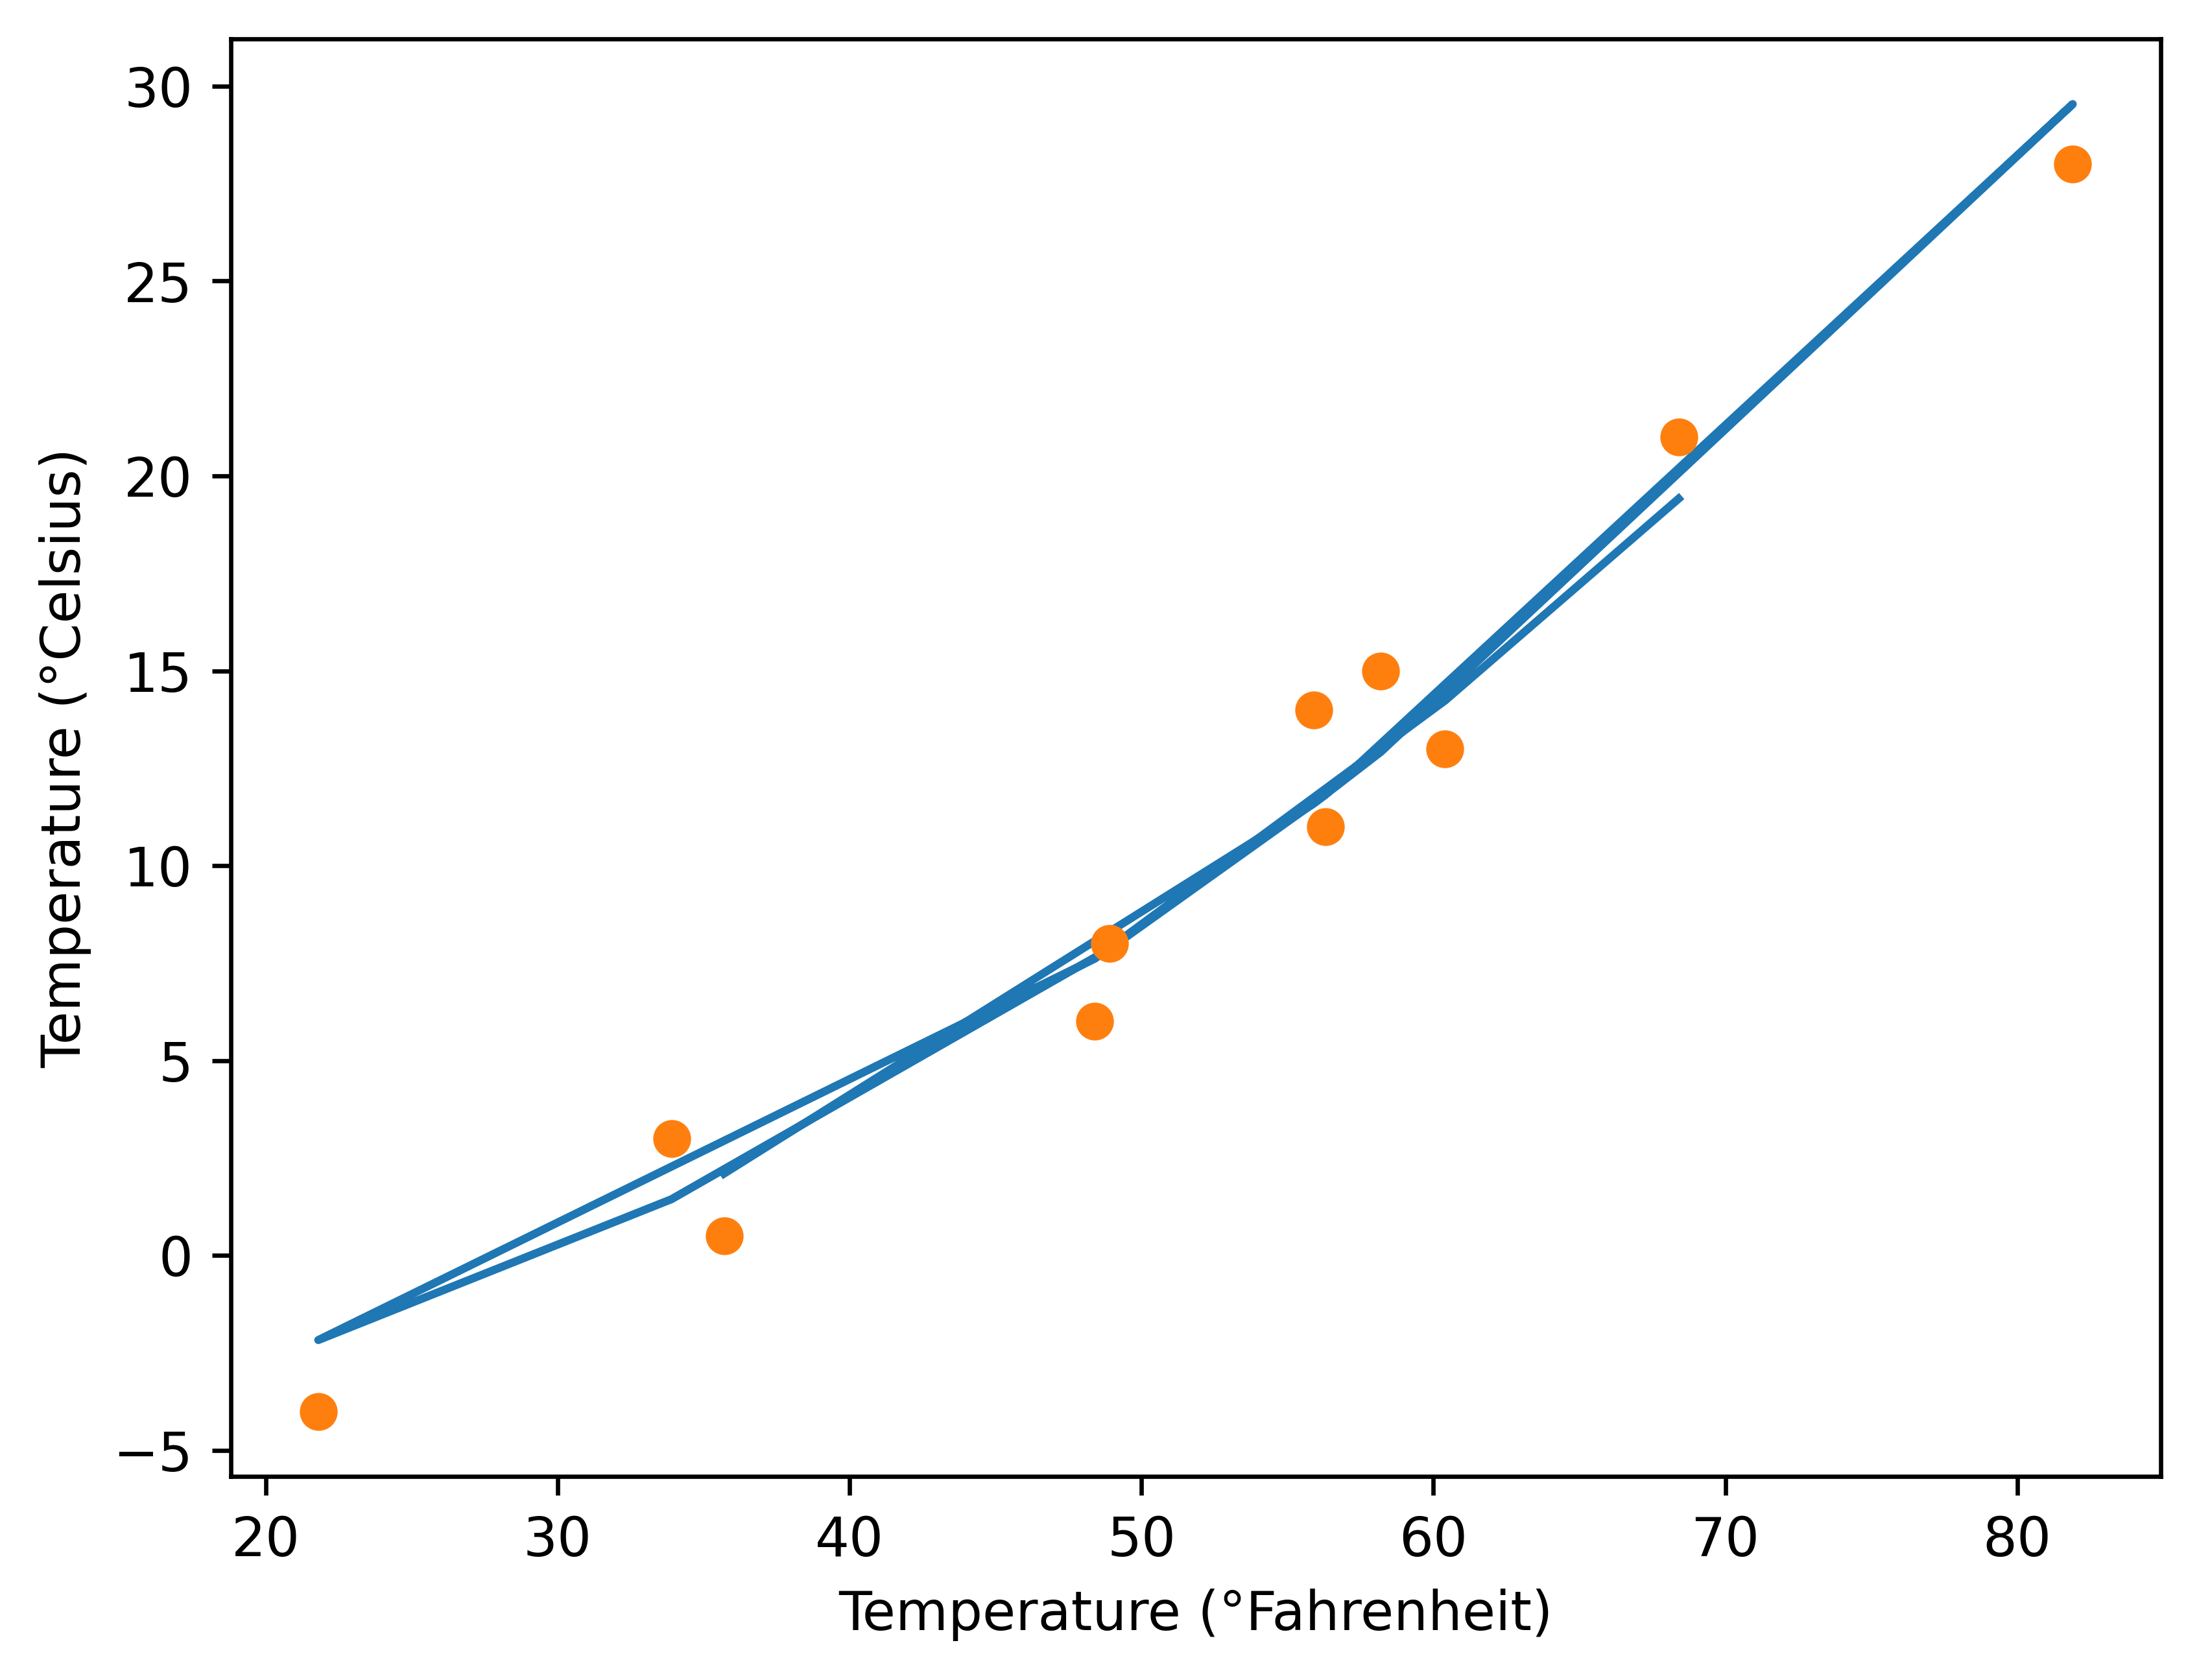

In [20]:
%matplotlib inline
from matplotlib import pyplot as plt

t_p = model(t_u, *params)  # <1>

fig = plt.figure(dpi=600)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy()) # <2> But we’re plotting the raw unknown values
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

### Excercise 6.5

<font color='red'>Experiment with the number of hidden neurons in our simple neural network
model, as well as the learning rate.<br>
a What changes result in more linear output from the model?<br></font>
ans> By changing the number of neurons to 70 and learning rate to 1e-3 we get a more or less linear output

<font color='red'>b Can you get the model to obviously overfit the data?</font><br>
ans> Training the model for more number of epochs will enable it to fit the training data more closely, potentially leading to overfitting. 

Use a neural network architecture with more layers, more neurons per layer, or both. Increasing the model complexity allows it to learn more intricate patterns in the training data, but it also increases the risk of overfitting


In [21]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1> input a singleton dimension at index 1
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

# t_u = torch.tensor(t_u) # shape is torch.Size([11]) for original tensor
t_u.shape

torch.Size([11, 1])

In [22]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 9,  0,  3,  6,  5, 10,  4,  1,  7]), tensor([2, 8]))

In [23]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [24]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # <1> The model is now passed in, instead of the individual params
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val) # <1> The model is now passed in, instead of the individual params
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")

Epoch 1, Training loss 203.5361, Validation loss 134.9246
Epoch 1000, Training loss 2.8530, Validation loss 4.0025
Epoch 2000, Training loss 2.1601, Validation loss 3.4210
Epoch 3000, Training loss 1.9273, Validation loss 3.1978
Epoch 4000, Training loss 1.8248, Validation loss 3.0900
Epoch 5000, Training loss 1.7758, Validation loss 3.0346


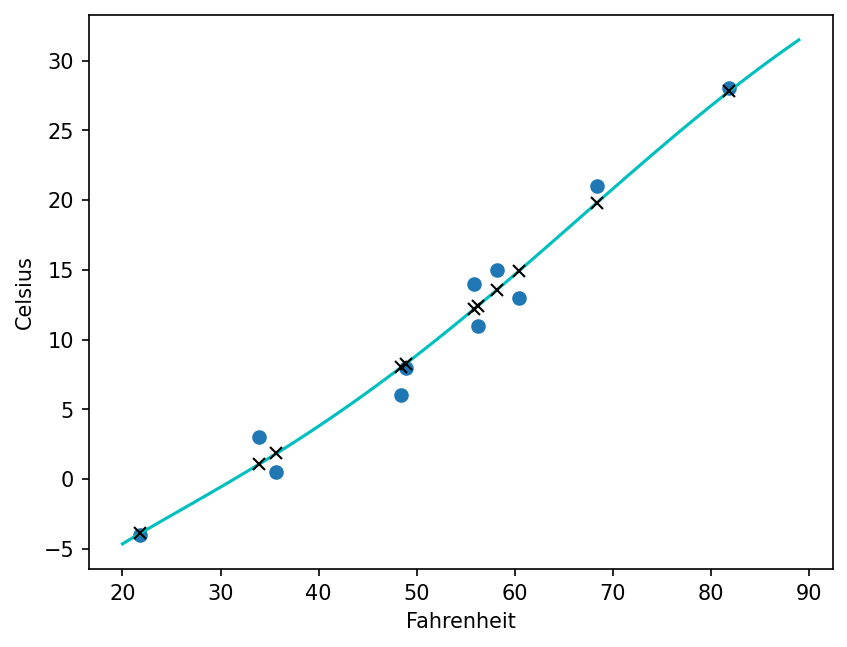

In [40]:
# Exercises here!
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from collections import OrderedDict


torch.set_printoptions(edgeitems=2, linewidth=75)
neuron_count = 70

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, neuron_count)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(neuron_count, 1))
]))

optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=150)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

Epoch 1, Training loss 202.7759, Validation loss 133.1592
Epoch 1000, Training loss 2.7787, Validation loss 3.9204
Epoch 2000, Training loss 2.0708, Validation loss 3.3168
Epoch 3000, Training loss 1.8646, Validation loss 3.1175
Epoch 4000, Training loss 1.7843, Validation loss 3.0350
Epoch 5000, Training loss 1.8754, Validation loss 3.1317
Epoch 6000, Training loss 1.8128, Validation loss 3.0325
Epoch 7000, Training loss 1.7763, Validation loss 2.9852
Epoch 8000, Training loss 1.7512, Validation loss 2.9621
Epoch 9000, Training loss 1.7352, Validation loss 2.9534
Epoch 10000, Training loss 1.7236, Validation loss 2.9528
Epoch 11000, Training loss 1.7167, Validation loss 2.9566
Epoch 12000, Training loss 1.7126, Validation loss 2.9621
Epoch 13000, Training loss 1.7101, Validation loss 2.9662
Epoch 14000, Training loss 1.7081, Validation loss 2.9675
Epoch 15000, Training loss 1.7061, Validation loss 2.9670


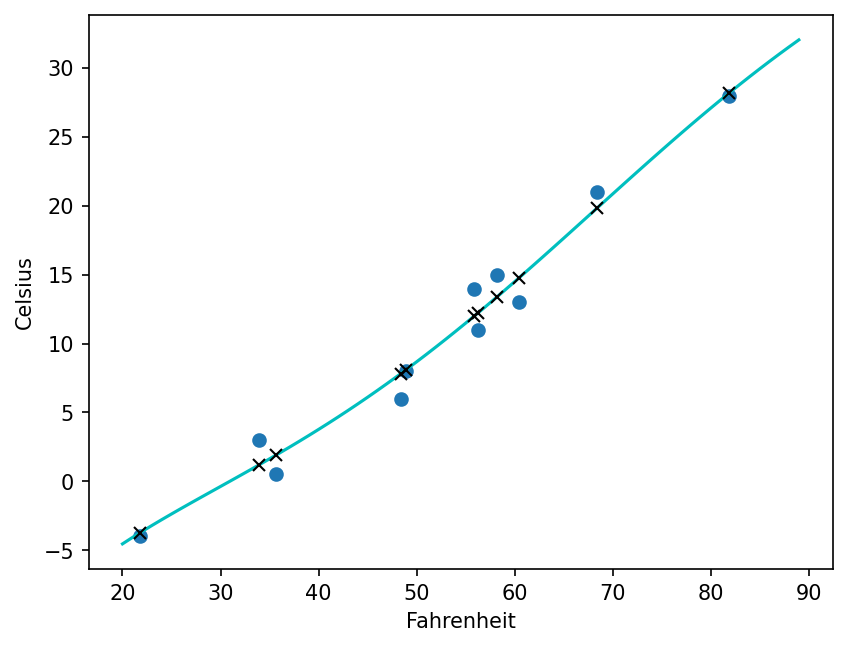

In [44]:
# Exercises here!
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from collections import OrderedDict


torch.set_printoptions(edgeitems=2, linewidth=75)
neuron_count = 70

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, neuron_count)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(neuron_count, 1))
]))

optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs = 15000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=150)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

### Excercise 7.4

<font color='red'>2 Switch loss functions (perhaps MSE).<br>
a Does the training behavior change?</font><br>
<font color='red'>3 Is it possible to reduce the capacity of the network enough that it stops overfitting?<br>
a How does the model perform on the validation set when doing so?</font>


In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [3]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [4]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [5]:
# for MSELoss()
label_map = {0: 0.0, 2: 1.0}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10 
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [6]:
for img, label in cifar2:
    label = torch.tensor([label]).unsqueeze(1)
print(label.shape)

torch.Size([1, 1])


In [7]:
img.view(-1).shape

torch.Size([3072])

In [8]:
img.shape

torch.Size([3, 32, 32])

In [9]:
img.view(-1).unsqueeze(0)

tensor([[ 0.3123,  0.4075,  ..., -0.9134, -0.8985]])


No, it's not common to use both LogSoftmax activation and Mean Squared Error (MSE) loss together in a neural network. LogSoftmax is typically used when the problem is a classification task, where the network outputs probability scores for each class. On the other hand, MSE loss is used for regression tasks, where the network outputs continuous values.

In [19]:
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 1))

In [20]:
img_batch = img.view(-1).unsqueeze(0)
img_batch,img_batch.size()

(tensor([[0.0582, 0.6139,  ..., 0.3308, 0.2259]]), torch.Size([1, 3072]))

In [21]:
out = model(img_batch)
out

tensor([[0.0165]], grad_fn=<AddmmBackward0>)

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim

# Making the code device-agnostic
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 1)
            )

# Transferring the model to a CUDA enabled GPU
model = model.to(device)

learning_rate = 1e-2
# 1e-2 the loss is nan
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_fn = nn.MSELoss()

n_epochs = 100

for epoch in range(n_epochs):
    for img, label in cifar2:
        # Move input tensors to the selected device
        img = img.to(device)
        out = model(img.view(-1).unsqueeze(0)) #(1,3072) - > model -> (1,1)
        loss = loss_fn(out, torch.tensor([label]).unsqueeze(0).to(device))
                
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 7.689123
Epoch: 1, Loss: 0.512793
Epoch: 2, Loss: 2.606145
Epoch: 3, Loss: 1.396571
Epoch: 4, Loss: 3.801548
Epoch: 5, Loss: 0.671886
Epoch: 6, Loss: 1.220460
Epoch: 7, Loss: 11.140194
Epoch: 8, Loss: 0.001555
Epoch: 9, Loss: 0.334232
Epoch: 10, Loss: 1.433770
Epoch: 11, Loss: 2.521858
Epoch: 12, Loss: 15.315101
Epoch: 13, Loss: 3.928722
Epoch: 14, Loss: 5.477810
Epoch: 15, Loss: 3.549740
Epoch: 16, Loss: 12.863299
Epoch: 17, Loss: 1.644346
Epoch: 18, Loss: 11.712065
Epoch: 19, Loss: 0.208397
Epoch: 20, Loss: 0.075882
Epoch: 21, Loss: 21.993359
Epoch: 22, Loss: 10.907895
Epoch: 23, Loss: 0.012433
Epoch: 24, Loss: 0.824285
Epoch: 25, Loss: 0.439521
Epoch: 26, Loss: 0.489821
Epoch: 27, Loss: 4.000781
Epoch: 28, Loss: 4.566396
Epoch: 29, Loss: 5.660903
Epoch: 30, Loss: 0.064890


KeyboardInterrupt: 

Changing the loss function from Negative Log Likelihood (NLLLoss) to Mean Squared Error (MSELoss) can lead to several changes in the training behavior of a neural network. Here are some potential differences:

1. **Convergence Behavior**: NLLLoss is commonly used for classification tasks, where the model outputs class probabilities. It encourages the model to produce high probabilities for the correct classes. On the other hand, MSELoss is often used for regression tasks, where the model predicts continuous values. MSELoss encourages the model to produce predictions that are close to the ground truth values. Switching from NLLLoss to MSELoss may change the convergence behavior of the training process, as the optimization landscape and gradients differ between the two loss functions.

2. **Output Interpretation**: NLLLoss is typically used with softmax activations, where the model outputs probability distributions over classes. The output can be interpreted as probabilities, making it suitable for classification tasks. MSELoss, on the other hand, is often used with linear or sigmoid activations, where the model outputs continuous values. The output of the model may change in interpretation from class probabilities to continuous predictions.

3. **Sensitivity to Outliers**: MSELoss is sensitive to outliers in the data, as it penalizes large errors quadratically. If there are outliers in the dataset, switching to MSELoss may lead to increased sensitivity to these outliers, potentially affecting the training behavior.

4. **Loss Scale**: The scale of the loss values may change between NLLLoss and MSELoss. NLLLoss values are typically in the range of 0 to infinity, while MSELoss values are squared errors and can potentially be larger. This difference in scale may require adjustments to the learning rate and other hyperparameters during training.

5. **Model Performance**: The choice of loss function can affect the final performance of the trained model. While NLLLoss is commonly used for classification tasks and MSELoss for regression tasks, the choice may also depend on the specific characteristics of the dataset and the problem at hand. Switching the loss function may lead to changes in the model's performance on validation or test data.

Overall, changing the loss function from NLLLoss to MSELoss can significantly alter the training behavior and characteristics of the neural network. It's essential to carefully consider the nature of the problem, the characteristics of the dataset, and the desired properties of the trained model when making such changes.

#### 3 Is it possible to reduce the capacity of the network enough that it stops overfitting?
#### a How does the model perform on the validation set when doing so?

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 32),
            nn.Tanh(),
            nn.Linear(32, 2),
            nn.LogSoftmax(dim=1))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        labels = labels.long()
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss))) #Due to the shuffling, this now prints the loss for a random batch—bb

Epoch: 0, Loss: 0.545978
Epoch: 1, Loss: 0.406217
Epoch: 2, Loss: 0.536329
Epoch: 3, Loss: 0.296942
Epoch: 4, Loss: 0.370012
Epoch: 5, Loss: 0.356622
Epoch: 6, Loss: 0.389535
Epoch: 7, Loss: 0.338020
Epoch: 8, Loss: 0.622315
Epoch: 9, Loss: 0.386573
Epoch: 10, Loss: 0.535265
Epoch: 11, Loss: 0.355718
Epoch: 12, Loss: 0.202925
Epoch: 13, Loss: 0.399373
Epoch: 14, Loss: 0.131313
Epoch: 15, Loss: 0.296345
Epoch: 16, Loss: 0.252988
Epoch: 17, Loss: 0.333478
Epoch: 18, Loss: 0.493909
Epoch: 19, Loss: 0.276053
Epoch: 20, Loss: 0.413289
Epoch: 21, Loss: 0.293386
Epoch: 22, Loss: 0.366526
Epoch: 23, Loss: 0.187919
Epoch: 24, Loss: 0.572719
Epoch: 25, Loss: 0.548486
Epoch: 26, Loss: 0.225647
Epoch: 27, Loss: 0.340511
Epoch: 28, Loss: 0.327264
Epoch: 29, Loss: 0.185426
Epoch: 30, Loss: 0.319516
Epoch: 31, Loss: 0.130049
Epoch: 32, Loss: 0.275784
Epoch: 33, Loss: 0.191922
Epoch: 34, Loss: 0.165360
Epoch: 35, Loss: 0.612089
Epoch: 36, Loss: 0.109720
Epoch: 37, Loss: 0.323099
Epoch: 38, Loss: 0.184

In [24]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.996300


In [25]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.800000


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 64),
            nn.Tanh(),
            nn.Linear(64, 2),
            nn.LogSoftmax(dim=1))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        labels = labels.long()
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss))) #Due to the shuffling, this now prints the loss for a random batch—bb

Epoch: 0, Loss: 0.329881
Epoch: 1, Loss: 0.442525
Epoch: 2, Loss: 0.657830
Epoch: 3, Loss: 0.416355
Epoch: 4, Loss: 0.494589
Epoch: 5, Loss: 0.354666
Epoch: 6, Loss: 0.453346
Epoch: 7, Loss: 0.455449
Epoch: 8, Loss: 0.417377
Epoch: 9, Loss: 0.374664
Epoch: 10, Loss: 0.457811
Epoch: 11, Loss: 0.303596
Epoch: 12, Loss: 0.270523
Epoch: 13, Loss: 0.136814
Epoch: 14, Loss: 0.258046
Epoch: 15, Loss: 0.472082
Epoch: 16, Loss: 0.464704
Epoch: 17, Loss: 0.277044
Epoch: 18, Loss: 0.214122
Epoch: 19, Loss: 0.266158
Epoch: 20, Loss: 0.198408
Epoch: 21, Loss: 0.390214
Epoch: 22, Loss: 0.227506
Epoch: 23, Loss: 0.208423
Epoch: 24, Loss: 0.397817
Epoch: 25, Loss: 0.176478
Epoch: 26, Loss: 0.157709
Epoch: 27, Loss: 0.237457
Epoch: 28, Loss: 0.221653
Epoch: 29, Loss: 0.261983
Epoch: 30, Loss: 0.124597
Epoch: 31, Loss: 0.129773
Epoch: 32, Loss: 0.181282
Epoch: 33, Loss: 0.217030
Epoch: 34, Loss: 0.077031
Epoch: 35, Loss: 0.239382
Epoch: 36, Loss: 0.284999
Epoch: 37, Loss: 0.222451
Epoch: 38, Loss: 0.342

In [27]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.998500


In [28]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.815500
